## PASSO 0) Imports

In [28]:
import sys
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!{sys.executable} -m pip install chardet
import chardet

- [Fase 2](#Fase-2)
- [Fase 3](#Fase-3)
- [Fase 4](#Fase-4)
- [Relatório](#Relatório)
- [Perguntas](#Perguntas)

### 0.1) Funções Auxiliares

In [29]:
def find_outliers_tucker(series, threshold=1.5):
    """
    Retorna os índices dos valores obtidos como outliers após calculados os limites superiores
    e inferiores da Series em questão, utilizando o algoritmo de Tucker.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - threshold * iqr
    upper_limit = q3 + threshold * iqr

    filtered_series = series[(series < lower_limit) | (series > upper_limit)]
    
    return filtered_series.index

def imputa_rua(bairro, df):
    return df[bairro]

def imputa_bairro(rua, df):
    rua_formatted = rua.split(',')[0]
    imoveis = df.loc[df['Rua'] == rua_formatted]

    if imoveis.shape[0] == 0:
        bairro = None
    else:
        bairro = imoveis['Bairro'].unique()[0]

    return bairro

def jupyter_settings():
    %matplotlib inline
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (24, 12)
    plt.rcParams['font.size'] = 24
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', 100)

    sns.set()

jupyter_settings()

### 0.2) Carregando os Dados

Carregando **dataset de imóveis** à venda na cidade de São Paulo

In [30]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


<a id="Fase-2"></a>

# FASE 2
___

## PASSO 1) Descrição dos Dados

In [31]:
df1_imoveis = df_imoveis.copy()

In [32]:
print('Número de linhas: ', df1_imoveis.shape[0])
print('Número de colunas: ', df1_imoveis.shape[1])

Número de linhas:  10008
Número de colunas:  8


In [33]:
df1_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### 1.1) Tipos dos Dados

In [34]:
df1_imoveis.dtypes

Rua          object
Bairro       object
Cidade       object
Metragem      int64
Quartos       int64
Banheiros     int64
Vagas         int64
Valor        object
dtype: object

O tipo da coluna `Valor` está errado, devendo ser transformada para numérica. Escolhemos transformá-la para int64, o que será feito mais a frente na *seção 1.3*.

### 1.2) Valores Nulos

In [35]:
df1_imoveis.isna().sum()

Rua          3434
Bairro         12
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

As variáveis `Rua` e `Bairro` possuem valores nulos que precisam ser tratados posteriormente.

# 1.3) Tratando Valores Nulos - RELATÓRIO

Preenchendo valores nulos da coluna `Bairro`

In [36]:
df1_imoveis[df1_imoveis['Bairro'].isna()]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
7263,"Rua Madalena de Morais, 3773",NaN,São Paulo,742,4,8,6,R$ 9.800\r\n /Mês
7956,Rua Vergueiro,NaN,São Paulo,103,3,2,2,R$ 640.000
7996,"Rua Alvorada do Sul, 3773",NaN,São Paulo,678,4,8,8,R$ 6.895.000
8126,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,550,3,5,6,R$ 4.000.000
8566,"Avenida Comendador Adibo Ares, 3773",NaN,São Paulo,694,4,6,6,R$ 3.890.000
8619,"Rua Alvorada do Sul, 3773",NaN,São Paulo,683,4,8,8,R$ 6.895.000
8739,"Rua Alvorada do Sul, 3773",NaN,São Paulo,683,4,8,8,R$ 6.895.000
8868,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,R$ 4.000.000
8943,"Rua Santo Eufredo, 3773",NaN,São Paulo,846,4,8,8,R$ 30.000\r\n /Mês
8992,"Rua Professor Eduardo Monteiro, 3773",NaN,São Paulo,555,3,5,6,R$ 4.000.000


#### 1.3.1) Tratando as ruas com número

Após verificar os nomes das ruas, descobrimos que há algumas com números:

In [37]:
df1_imoveis[df1_imoveis['Rua'].str.contains(',') & df1_imoveis['Rua'].notna()].sample(10)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
7476,"Rua Geremia Lunardelli, 382",Jardim Peri Peri,São Paulo,200,3,5,4,R$ 900.000
2944,"Rua Brigadeiro Gama Barcelos, 303",Parque Jabaquara,São Paulo,145,2,4,2,R$ 540.000
137,"Rua Aquiramun, 94",Alto de Pinheiros,São Paulo,450,5,6,5,R$ 5.500.000
7786,"Rua João Vilhema, 22",Planalto Paulista,São Paulo,175,3,3,2,R$ 4.800\r\n /Mês
8649,"Rua Cordisburgo, 251",Jardim Leonor,São Paulo,855,4,4,6,R$ 6.500.000
5668,"Rua Wagih Assad Abdalla, 138",Morumbi,São Paulo,683,4,6,4,R$ 10.000\r\n /Mês
6844,"Rua Salvador Fiordelisio, 160",Vila Bertioga,São Paulo,77,3,4,2,R$ 599.000
9793,"Rua João Lopes de Amorim, 405",Vila Nova Cachoeirinha,São Paulo,235,3,5,3,R$ 520.000
552,"Rua Conselheiro Brotero, 121",Barra Funda,São Paulo,170,3,2,2,R$ 745.000
462,"Rua Bernardino de Campos, 731",Campo Belo,São Paulo,180,3,3,2,R$ 900.000


O que poderá acarretar em distorções nos gráficos, criando variáveis diferentes para ruas iguais. Por exemplo:

In [38]:
df1_imoveis[df1_imoveis['Rua'].str.contains('Alameda dos Anapurus') & df1_imoveis['Rua'].notna()]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
370,Alameda dos Anapurus,Indianópolis,São Paulo,218,3,3,3,R$ 1.745.000
1868,Alameda dos Anapurus,Indianópolis,São Paulo,320,2,1,6,R$ 1.980.000
1880,"Alameda dos Anapurus, 500",Indianópolis,São Paulo,400,5,6,5,R$ 4.000.000
1970,Alameda dos Anapurus,Indianópolis,São Paulo,325,2,1,6,R$ 1.980.000
1982,"Alameda dos Anapurus, 500",Indianópolis,São Paulo,405,5,6,5,R$ 4.000.000
2300,Alameda dos Anapurus,Indianópolis,São Paulo,218,3,3,3,R$ 1.690.000
7215,"Alameda dos Anapurus, 194",Indianópolis,São Paulo,600,4,7,6,R$ 3.300.000
7305,"Alameda dos Anapurus, 194",Indianópolis,São Paulo,605,4,7,6,R$ 3.300.000
9772,"Alameda dos Anapurus, 1885",Indianópolis,São Paulo,218,3,2,3,R$ 1.690.000


Como podemos observar, temos 9 ruas de mesmo nome. Se criarmos algum gráfico com um dos eixos sendo a coluna Rua, teremos 4 elementos para uma mesma rua, gerando assim dados errados.


Corrigindo os nomes da variável `Rua`

In [39]:
df1_imoveis['Rua'] = df1_imoveis['Rua'].str.split(',').str[0]

---

In [40]:
df1_imoveis.loc[df1_imoveis['Rua'] == 'Rua Madalena de Morais']

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
1333,Rua Madalena de Morais,Jardim Leonor,São Paulo,950,4,3,4,R$ 4.000.000
3155,Rua Madalena de Morais,Jardim Leonor,São Paulo,800,5,8,6,R$ 8.000.000
7263,Rua Madalena de Morais,NaN,São Paulo,742,4,8,6,R$ 9.800\r\n /Mês
7458,Rua Madalena de Morais,Jardim Leonor,São Paulo,726,4,8,9,R$ 4.500.000


Nota-se que existem imóveis no dataset que são da mesma Rua e que algum deles possui o valor correto da coluna Bairro. Basta imputar-mos estes valores aos imóveis com o dado faltante, para isso iremos criar um função `imputa_bairro()` que será definida na *seção 0.2*.

In [41]:
# removendo os valores nulos da coluna Bairro atraves da funcao imputa_bairro()
df1_imoveis['Bairro'] = df1_imoveis.apply(lambda x: x['Bairro'] if pd.notnull(x['Bairro']) \
                                else imputa_bairro(x['Rua'], df1_imoveis), axis=1)

In [42]:
# checando novamente o número de valores nulos na coluna bairro após a primeira limpeza
df1_imoveis.isna().sum()[df1_imoveis.isna().sum() > 0]

Rua       3434
Bairro       1
dtype: int64

Nota-se que restou apenas um imóvel com valor nulo na coluna `Bairro`, o qual nós iremos dropar do dataset.

In [43]:
# dropando o dado com valor nulo
df1_imoveis.dropna(subset=['Bairro'], inplace=True)

# checando novamente a quantiadde de valores nulos
print(f'Total de valores nulos na coluna Bairro = {df1_imoveis["Bairro"].isna().sum()}')

Total de valores nulos na coluna Bairro = 0


Preenchendo valores nulos da variável `Rua`

In [44]:
df1_imoveis.loc[df1_imoveis['Rua'].isna(), :].head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
11,NaN,Jardim Luzitânia,São Paulo,436,4,3,3,R$ 15.000
31,NaN,Parque da Lapa,São Paulo,220,4,4,3,R$ 849.000
56,NaN,Chácara Santo Antônio (Zona Sul),São Paulo,190,2,2,2,R$ 1.100.000
57,NaN,Jardim Guedala,São Paulo,650,4,6,4,R$ 5.500.000


Anteriormente nós garantimos que não existem dados com valores nulos para a coluna Bairro, uma das soluções para imputar a variável Rua seria obter uma Rua aleatório do mesmo bairro do dado em questão, outra solução seria simplesmente deletar todos os dados com valores de Rua faltante.

In [45]:
# Analisando a viabilidade de deletar todas as linhas com Rua faltante
tot_sem_rua = df1_imoveis.loc[df1_imoveis['Rua'].isna(), :].shape[0]
porc_sem_rua = tot_sem_rua / df_imoveis.shape[0] * 100
print(f'Porcentagem dos dados com valores faltantes para a coluan Rua = {porc_sem_rua:.2f}%')

Porcentagem dos dados com valores faltantes para a coluan Rua = 34.31%


Cerca de **35%** dos dados em nosso conjunto de dados não possuem valor para a variável Rua, o que é uma parcela bastante significativa. A simples exclusão destes dados acarretaria numa perda significativa da informação como um todo, por isso decidimos mantê-los e atribuir um valor aleatório de rua que seja do mesmo Bairro.

In [46]:
# agrupa os dados por bairro e obtem a rua mais frequente para cada bairro 
# ou None caso o bairro nao possua ruas no dataset
#df_bairros = df1_imoveis.groupby('Bairro')['Rua'].agg(lambda x: x.mode().iat[0] if len(x.mode()) > 0 else None)

In [47]:
# removendo os valores nulos da coluna Bairro atraves da funcao imputa_bairro()
#df1_imoveis['Rua'] = df1_imoveis.apply(lambda x: x['Rua'] if pd.notnull(x['Rua']) \
#                                else imputa_rua(x['Bairro'], df_bairros), axis=1)

In [48]:
# checando novamente o número de valores nulos na coluna Rua após a primeira limpeza
#df1_imoveis.isna().sum()[df1_imoveis.isna().sum() > 0]

In [49]:
#df1_imoveis.dropna(subset=['Rua'], inplace=True)

Por fim, checando o valor atualizado de valores nulos que deve ser igual a 0. Nosso dataset agora está limpo.

In [50]:
df1_imoveis.isna().sum()

Rua          3434
Bairro          0
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

Após analisar o resultado da nossa atribuição de ruas, vimos que, examinando as ruas dos imóveis no Google Maps, algumas não condiziam com os dados dos imóveis, seja em tamanho do imóvel ou em valor. Gerando assim, resultados totalmente diferentes e imprecisos na montagem dos gráficos, com isso decidimos manter as ruas sem valor e focar nossa análise a partir dos bairros.

# MANTER NA SEÇÃO DA FASE 2       V

### 1.3) Buscando Variáveis com Tipos de Dados Incorretos

**Variável `Valor`**

Analisando os valores desta coluna descobrimos que ela não somente mostra o valor absoluto das casas, mas para algumas linhas ela mostra o valor do aluguel, podendo este ser diário, mensal ou anual.

Aluguel Diário

In [51]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6639,NaN,Jardim Guedala,São Paulo,572,4,6,7,R$ 15.000\r\n /Dia
7421,NaN,Jardim Guedala,São Paulo,577,4,6,7,R$ 15.000\r\n /Dia


Aluguel Mensal

In [52]:
df_imoveis_alugar = df1_imoveis[df1_imoveis['Valor'].str.contains('Mês')]
df_imoveis_alugar.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
151,Rua Fonseca da Costa,Bosque da Saúde,São Paulo,650,4,6,12,R$ 11.000\r\n /Mês
156,NaN,Jardim Paulistano,São Paulo,230,2,3,2,R$ 12.000\r\n /Mês
175,Rua Maestro Elias Lobo,Jardim Paulista,São Paulo,542,5,8,4,R$ 25.000\r\n /Mês
178,Rua Guararapes,Lapa,São Paulo,515,3,5,8,R$ 30.000\r\n /Mês
182,Rua Alvarenga,Butantã,São Paulo,400,4,3,4,R$ 10.000\r\n /Mês


In [53]:
alugar_prct = df_imoveis_alugar.shape[0] / df1_imoveis.shape[0]  * 100
print(f"Porcentagem de imoveis com alguel mensal: {alugar_prct:.2f}%")

Porcentagem de imoveis com alguel mensal: 8.47%


Aluguel Anual

In [54]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6029,NaN,Instituto de Previdência,São Paulo,120,3,1,2,R$ 2.600\r\n /Ano
6718,NaN,Instituto de Previdência,São Paulo,125,3,1,2,R$ 2.600\r\n /Ano


### Deletando esses imóveis:

In [58]:
# Deletando os imóveis de aluguel DIÁRIO
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')].index, inplace=True)

# Deletando e salvando os imóveis de aluguel MENSAL
df1_imoveis.drop(df_imoveis_alugar.index, inplace=True)
df_imoveis_alugar.to_csv('./dados/dados_imoveis_alugar.csv')

# Deletando os imóveis de aluguel ANUAL
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')].index, inplace=True)

A partir da nossa análise, descobrimos que o dataset de imóveis não somente compreende casas para vender, mas também casas para alugar. Essas casas correspondem a cerca de 8.47% do dataset completo, nossa decisão foi salvar esses dados em um arquivo .csv único, que separa essas casas do restante e nos permite posteriormente examinar a viabilidade de realizar análises direcionadas para elas, removendo-as do dataframe original.

**Resolvendo o tipo incorreto**

In [55]:
df1_imoveis['Valor'].sample(5)

6915     R$ 4.560.000
8999     R$ 5.000.000
7425     R$ 2.200.000
2200     R$ 1.650.000
9556    R$ 14.900.000
Name: Valor, dtype: object

Corrigindo o tipo de dado da variável `Valor`

In [56]:
# Casting da variável Valor de Object para int64
df1_imoveis['Valor'] = df1_imoveis['Valor']\
    .str.replace('R\$|,', '', regex=True)\
        .str.replace('.', '').str.strip()

In [59]:
df1_imoveis['Valor'] = df1_imoveis['Valor'].astype(int)
df1_imoveis['Valor'].sample(5)

3295     1100000
703      5000000
4919     2150000
4492     7900000
6213    12000000
Name: Valor, dtype: int32

### 1.4) Fazendo ajustes adicionais RELATORIO

Descobrimos que no dataset havia na coluna 'Bairro' os valores Jardim Europa, Jardim Paulista, Jardim Paulistano, Jardim América e Jardins. Porém os quatro primeiros formam a Região dos Jardins, como não sabemos de qual bairro são os imóveis que estão em Jardins decidimos alterar o nome dos quatro primeiros para Jardins.

In [60]:
df1_imoveis[df1_imoveis['Bairro'].str.contains('Jardim América') 
            | df1_imoveis['Bairro'].str.contains('Jardim Europa')
            | df1_imoveis['Bairro'].str.contains('Jardim Paulista')
            | df1_imoveis['Bairro'].str.contains('Jardim América')]

df1_imoveis['Bairro'] = df1_imoveis['Bairro'].replace({'Jardim Europa': 'Jardins', 'Jardim Paulista': 'Jardins',
                                           'Jardim Paulistano': 'Jardins', 'Jardim América': 'Jardins'})

df1_imoveis[df1_imoveis['Bairro'].str.contains('Jardins')]


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
60,Rua Inglaterra,Jardins,São Paulo,200,3,3,2,13000
67,Rua Bolívia,Jardins,São Paulo,663,4,7,6,14500000
68,Rua General Fonseca Teles,Jardins,São Paulo,420,4,6,3,8700000
98,Rua Marechal Bitencourt,Jardins,São Paulo,360,4,5,4,1800000
102,Rua Inglaterra,Jardins,São Paulo,756,5,4,10,37000000
...,...,...,...,...,...,...,...,...
9823,NaN,Jardins,São Paulo,870,5,5,3,12600000
9841,NaN,Jardins,São Paulo,720,6,6,5,9800000
9873,NaN,Jardins,São Paulo,303,3,5,2,2450000
9882,NaN,Jardins,São Paulo,575,4,6,4,11000000


# COLOCAR NO RELATÓRIO APOS MOSTRAR O BOXPLOT

Feita a alteração descobrimos um imóvel no dataframe acima, com valor errado, possívelmente é um valor de aluguel que conseguiu "escapar" da remoção dos imóveis para alugar feita anteriormente.

In [61]:
# Verificando se existem imóveis nas mesmas condições
df1_imoveis[df1_imoveis['Valor'] < 100000]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
11,NaN,Jardim Luzitânia,São Paulo,436,4,3,3,15000
60,Rua Inglaterra,Jardins,São Paulo,200,3,3,2,13000


In [62]:
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'] <= 15000].index, inplace=True)

**Removendo imóveis desproporcionais**

Verificando os imóveis temos alguns que estão desproporcionais, possívelmente foram adicionados com erros de digitação e não serão significativos neste trabalho. Temos imóveis com mais de 30 vagas, por exemplo, e que poderão gerar distorções nas montagens dos gráficos. Com isso decidimos removê-los.

In [ ]:
#df1_imoveis[df1_imoveis['Vagas'] >= 30]

In [ ]:
#df1_imoveis.drop(df1_imoveis[df1_imoveis['Vagas'] >= 30].index, inplace = True)

In [ ]:
df1_imoveis.drop_duplicates(subset=df1_imoveis.columns.difference(['Metragem']), inplace=True)

Verificando a Metragem:

In [ ]:
df1_imoveis[df1_imoveis.duplicated(keep=False)].sort_values(by=['Valor'])

In [ ]:
df1_imoveis.drop_duplicates(inplace = True)

In [ ]:
df1_imoveis[(df1_imoveis['Metragem'] >= 35000)]

In [ ]:
df1_imoveis[(df1_imoveis['Metragem'] <= 50) & (df1_imoveis['Quartos'] >= 3)]

In [ ]:
df1_imoveis.drop(df1_imoveis[df1_imoveis['Metragem'] >= 35000].index, inplace = True)
df1_imoveis.drop(df1_imoveis[(df1_imoveis['Metragem'] <= 50) & (df1_imoveis['Quartos'] >= 3)].index, inplace = True)

Verificando os quartos

In [ ]:
df1_imoveis[(df1_imoveis['Quartos'] >= 10) & (df1_imoveis['Valor'] <= 1000000) & (df1_imoveis['Metragem'] <= 400)]

In [ ]:
df1_imoveis.drop(df1_imoveis[(df1_imoveis['Quartos'] >= 10) & (df1_imoveis['Valor'] <= 1000000) & (df1_imoveis['Metragem'] <= 400)].index, inplace = True)

In [ ]:
df1_imoveis[(df1_imoveis['Quartos'] >= 10) & (df1_imoveis['Metragem'] <= 300)]

In [ ]:
df1_imoveis.drop(df1_imoveis[(df1_imoveis['Quartos'] >= 10) & (df1_imoveis['Metragem'] <= 300)].index, inplace = True)

Verificando os Banheiros:

In [ ]:
df1_imoveis[df1_imoveis['Banheiros'] >= 15]

In [ ]:
df1_imoveis.drop(df1_imoveis[df1_imoveis['Banheiros'] >= 15].index, inplace = True)

Verificando as vagas:

In [ ]:
df1_imoveis[(df1_imoveis['Vagas'] >= 20)]

In [ ]:
df1_imoveis.drop(df1_imoveis[df1_imoveis['Vagas'] >= 20].index, inplace = True)

In [ ]:
#df1_imoveis[df1_imoveis['Valor'] >= 30000000]


## PASSO 2) Criando Novas Colunas CONTINUA NA FASE 2

In [63]:
df2_imoveis = df1_imoveis.copy()

#### Criando a coluna `Valor_m2`

Representa o valor médio do m2 para cada linha do dataframe.

In [64]:
df2_imoveis['Valor_m2'] = df2_imoveis['Valor'] / df2_imoveis['Metragem']
df2_imoveis['Valor_m2'].head()

0   7000.00
1   7459.68
2   3040.00
3   2209.68
4   5400.00
Name: Valor_m2, dtype: float64

## PASSO 3) Estatísticas de Resumo

In [65]:
df3_imoveis = df2_imoveis.copy()

In [66]:
# dividindo o dataframe em variáveis numéricas e categóricas
num_attr, cat_attr = df3_imoveis.select_dtypes(include=[int, float]), df3_imoveis.select_dtypes(exclude=[int, float])

**Variáveis Numéricas**

In [67]:
num_attr.describe().rename({'count': 'Quantidade', 'max': 'Máximo', 'min': 'Mínimo', '50%': 'Mediana/Q2', 'mean': 'Média', '25%': 'Q1', '75%': 'Q3', 'std': 'Desvio Padrão'}).T

,Quantidade,Média,Desvio Padrão,Mínimo,Q1,Mediana/Q2,Q3,Máximo
Metragem,9153.00,434.45,7857.71,10.00,168.00,276.00,450.00,750000.00
Quartos,9153.00,3.45,1.05,1.00,3.00,3.00,4.00,16.00
Banheiros,9153.00,3.80,1.97,1.00,2.00,4.00,5.00,40.00
Vagas,9153.00,3.96,2.60,1.00,2.00,4.00,5.00,50.00
Valor,9153.00,3053025.48,3944569.61,130000.00,890000.00,1800000.00,3500000.00,65000000.00
Valor_m2,9153.00,8006.19,5290.75,9.33,4750.00,6500.00,9453.78,80000.00


Imprimindo boxplot para as variáveis numéricas

# removendo outliers RELATÓRIO
indexes_of_outliers = find_outliers_tucker(df3_imoveis['Metragem'])
df_cleaner = df3_imoveis.drop(indexes_of_outliers)
df_cleaner.shape

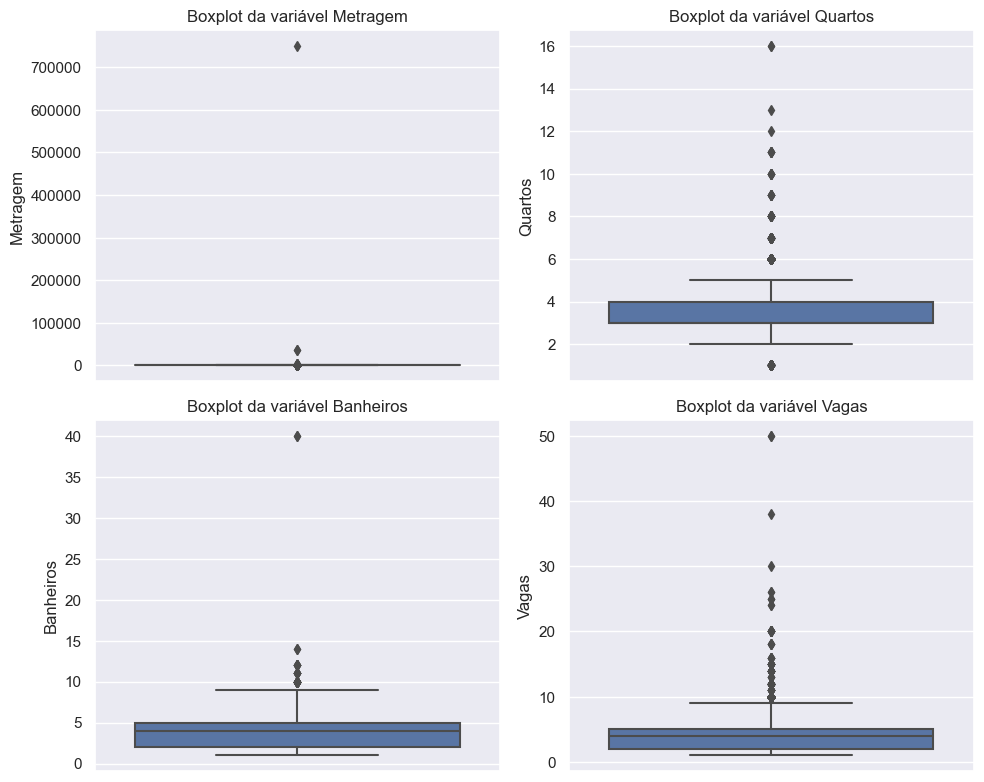

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Boxplot da variável Metragem
sns.boxplot(data=df3_imoveis, y='Metragem', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot da variável Metragem')

# Boxplot da variável Quartos
sns.boxplot(data=df3_imoveis, y='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot da variável Quartos')

# Boxplot da variável Banheiros
sns.boxplot(data=df3_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot da variável Banheiros')

# Boxplot da variável Vagas
sns.boxplot(data=df3_imoveis, y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot da variável Vagas')

plt.tight_layout()

plt.show()

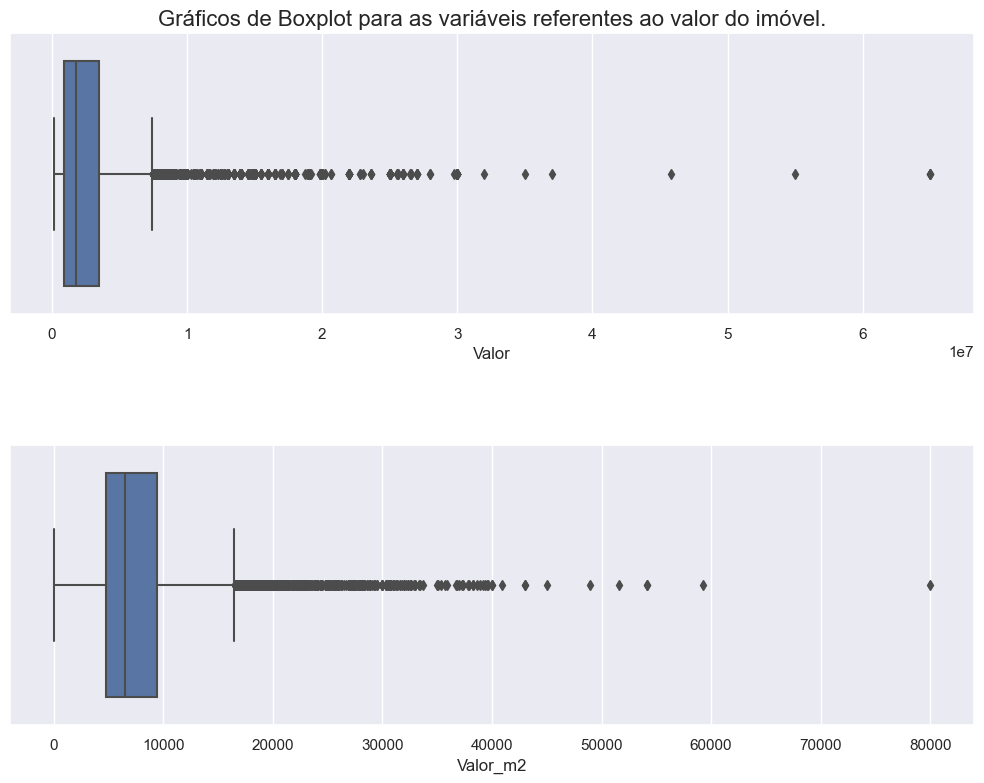

In [96]:
#new_indexes_to_drop = find_outliers_tucker(df_cleaner['Valor'])
#df_cleaner.drop(new_indexes_to_drop, inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.boxplot(data=df3_imoveis, x='Valor', ax=ax[0])

sns.boxplot(data=df3_imoveis, x='Valor_m2', ax=ax[1])

ax[0].set_title('Gráficos de Boxplot para as variáveis referentes ao valor do imóvel.', fontsize = 16)
plt.tight_layout(h_pad = 5)

plt.show()

**Variáveis Categóricas**

In [97]:
cat_attr.describe().rename({'count': 'Quantidade', 'unique': 'Qtd. Valores Únicos', 'top': 'Moda', 'freq': 'Freq. da Moda'}).T

,Quantidade,Qtd. Valores Únicos,Moda,Freq. da Moda
Rua,6105,2524,Rua Alberto Faria,29
Bairro,9153,693,Jardins,735
Cidade,9153,1,São Paulo,9153


# FASE 3
___

## PASSO 4) Análise Exploratória dos Dados

In [98]:
df4_imoveis = df3_imoveis.copy()
#df4_imoveis_sem_outliers = df3_imoveis.copy()

### 4.1) Análise Univariada

##### Variáveis Numéricas

##### `Metragem`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis_sem_outliers['Metragem'])
df4_imoveis_sem_outliers.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Metragem.')


Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis_sem_outliers, x='Metragem', ax=ax[0, 0])#, kde = True, log_scale = True, bins = 25)
ax[0, 0].set_title('Histograma da variável Metragem')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis_sem_outliers, x='Metragem', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Metragem', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis_sem_outliers, x='Valor', y='Metragem', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Quartos`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis_sem_outliers['Quartos']) 
df4_imoveis_sem_outliers.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Quartos.')


Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis_sem_outliers, x='Quartos', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de Quartos')
ax[0, 0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis_sem_outliers, x='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Quartos', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis_sem_outliers, x='Valor', y='Quartos', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Banheiros`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis_sem_outliers['Banheiros']) 
df4_imoveis_sem_outliers.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Banheiros.')

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis_sem_outliers, x='Banheiros', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de banheiros')
ax[0,0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis_sem_outliers, x='Banheiros', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis_sem_outliers, x='Valor', y='Banheiros', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Vagas`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis_sem_outliers['Vagas']) 
df4_imoveis_sem_outliers.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Vagas.')

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Vagas', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Vagas')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Vagas', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Vagas', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis['Valor']) 
df4_imoveis.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Valor.')

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Valor')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor_m2`

Removendo os valores nulos

In [ ]:
# dropando os valores nulos utilizando a funcao abaixo definida na seção 0.2 deste notebook
indexes_to_drop = find_outliers_tucker(df4_imoveis['Valor_m2']) 
df4_imoveis.drop(indexes_to_drop, inplace=True)

print(f'Foram dropados {indexes_to_drop.shape[0]} linhas consideradas outliers para a variável Valor_m2.')

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Valor_m2')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor_m2', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor_m2', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### Variáveis Categóricas

##### `Rua`

In [ ]:
df_rua = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_rua[:10], x = 'Valor', y='Rua')
plt.show()

##### `Bairro`

In [ ]:
df_bairros = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_bairros[:10], x = 'Valor', y='Bairro')
plt.show()

### 4.2) Análise Multivariada

### 4.3) Respondendo as Perguntas

1) **Quais os bairros onde os imóveis são mais valorizados, na média?**

In [ ]:
df_p1 = df4_imoveis.groupby('Bairro').agg({'Valor': 'mean'}).sort_values(by='Valor', ascending=False)\
    .reset_index()
df_p2 = df4_imoveis.groupby('Bairro').agg({'Valor': 'median'}).sort_values(by='Valor', ascending=False)\
    .reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))

sns.barplot(data=df_p1[:10], x='Bairro', y='Valor', ax=ax)
ax.set_title('TOP 10 Bairros por Valor Médio', size=28)
ax.set_ylabel('Preço médio (milhões de reais)', size=22)
ax.set_xlabel('Bairro', size=22)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))

sns.barplot(data=df_p2[:10], x='Bairro', y='Valor', ax=ax)
ax.set_title('TOP 10 Bairros por Valor Mediano', size=28)
ax.set_ylabel('Preço mediano (milhões de reais)', size=22)
ax.set_xlabel('Bairro', size=22)

plt.show()

2) **Qual o preço médio do m2 nos bairros mais valorizados?**

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))

df_preco_m2 = df4_imoveis.groupby('Bairro').agg({'Valor': 'mean', 'Valor_m2':'mean'}).sort_values(by='Valor', ascending=False)\
    .reset_index()[:10]

del df_preco_m2['Valor']

df_preco_m2_sorted = df_preco_m2.sort_values(by='Valor_m2', ascending=False)

sns.barplot(data=df_preco_m2_sorted, x = 'Bairro', y = 'Valor_m2')
ax.set_title('Preço médio do m2 por bairro', size=28)
ax.set_ylabel('Preço médio do m2', size=22)
ax.set_xlabel('Bairro', size=22)

plt.show()

4) **A coluna metragem possui um valor de correlação de Pearson forte com o preço do imóvel (pelo menos 0.6)?**

**VERDADEIRO**. A correlação entre `Metragem` e `Valor` é de 0.77, sendo acima de 0.6 e considerada FORTE.

In [ ]:
correlation = df4_imoveis.corr( method='pearson' )
sns.heatmap( correlation, cmap='mako', annot=True );

Ao visualizar o gráfico acima nota-se o valor de 0.77 como a correlação entre as colunas `Valor` e `Metragem`, este valor de 0.77 é acima do limite estabelecido de 0.6 e também é considerado um valor classificado como FORTE para correlação entre duas variáveis numéricas. Portanto a nossa pergunta foi validada como VERDADEIRA.

6. **Para cada unidade acrescida na quantidade de 'Quartos', o preço médio dos imóveis aumenta em 10%?**

**ERRADO**.

In [ ]:
df_p6 = df4_imoveis_sem_outliers.groupby('Quartos').agg({"Valor": "mean"}).reset_index()
df_p6.sort_values(by='Valor').head(10)

In [ ]:
media_por_quarto = df_p6['Valor'].pct_change() * 100
media_por_quarto

In [ ]:
print(f"O aumento percentual médio no preço do Imóvel ao acrescentar um Quarto foi de {media_por_quarto.mean():.2f}% na média.")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=['2-2', '2-3', '3-4', '4-5'], y=media_por_quarto, ax=ax)
ax.set_title('Aumento percentual médio no preço do Imóvel por quantidade de Quartos')
ax.set_xlabel('De X para Y Quartos')
ax.set_ylabel('Aumento percentual médio (%)')

plt.show()